In [12]:
from scipy.optimize import curve_fit
from cycler import cycler
import glob, os
from astropy.io import fits
from scipy.ndimage import label, center_of_mass
from matplotlib.patches import Circle
from tools import *

In [13]:
%matplotlib widget

In [77]:
%matplotlib inline

In [20]:
header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 2570 / Axis length                                    
NAXIS2  =                 4611 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =           3.276800E4 /                                                
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2006-03-20T14:56:47' / Date FITS file was generated                  
IRAF-TLM= '14:56:45 (20/03/2006)' / Time of last modification                   
OBJECT  = 'Lockman_mosaic_r_1046+5902 - DelRA =   0.0, DelDec =   0.0' / Name of
NEXTEND =                   

## To do list

- Mask instead of cropping  
- Mask the central star better  
- Try not to crop out the background with the middle line  
- Improve plotting for literature data


# Preliminary

## Plot the original image 

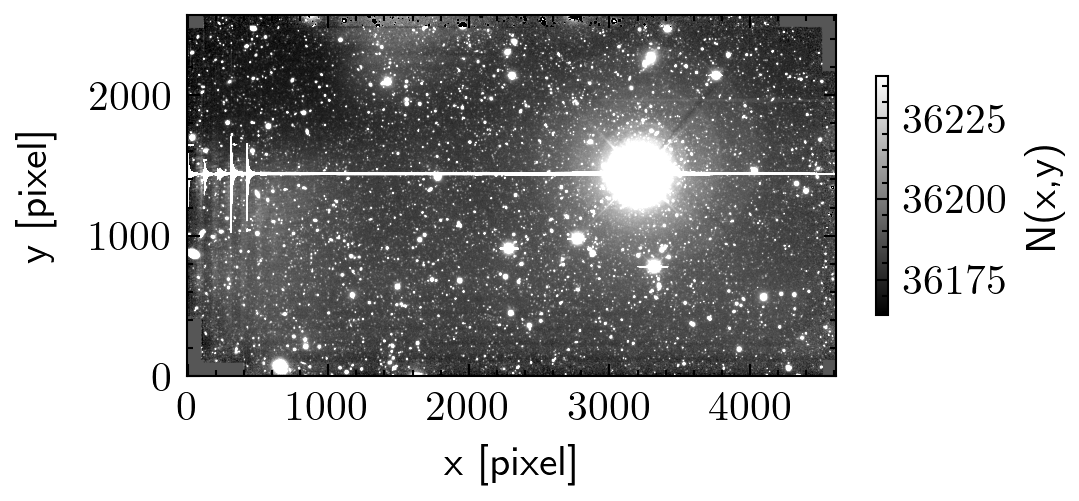

In [14]:
# Load the FITS file
with fits.open("data/Fits_Data/mosaic.fits") as hdul:
    image_data = hdul[0].data # this contains the count in each pixel
    header = hdul[0].header

# Apply scaling
# REAL = TAPE*BSCALE + BZERO                     
scaled_image = image_data.T * header.get('BSCALE', 1.0) + header.get('BZERO', 0.0)

# Get aspect ratio (width / height)
ny, nx = scaled_image.shape
aspect_ratio = nx / ny
enlarge = 0.7

# Plot
plt.figure(figsize=(3 * aspect_ratio * enlarge, 3 * enlarge), dpi=300)
plt.imshow(
    scaled_image,
    cmap='gray',
    origin='lower',
    vmin=np.percentile(scaled_image, 5),
    vmax=np.percentile(scaled_image, 95)
)
plt.title('')
plt.colorbar(label='N(x,y)', shrink=0.5)
plt.xlabel('x [pixel]')
plt.ylabel('y [pixel]', labelpad=8)
plt.tight_layout()
plt.show()

## Plot histogram for the original image (zoom into the Gaussian region)

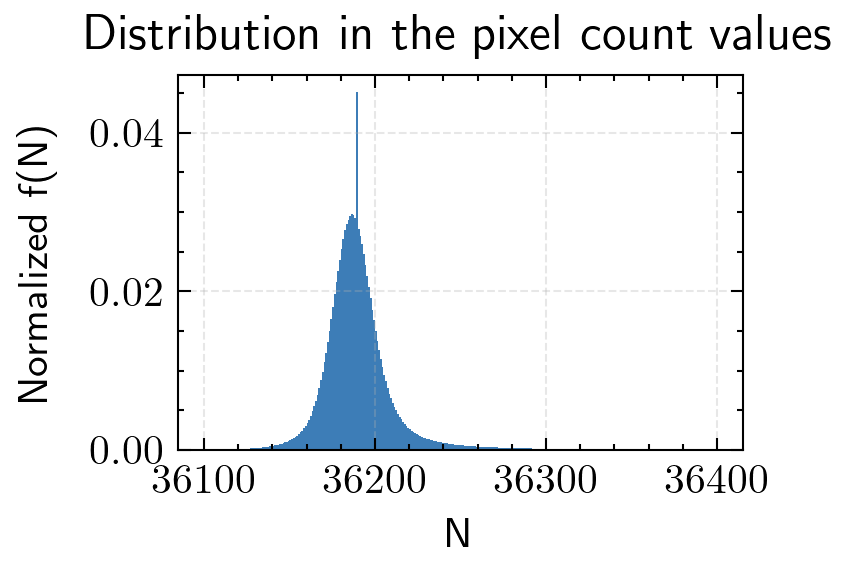

Mean: 36190.280
Std:  23.619


In [15]:
# Flatten to 1D array of counts
pixels = scaled_image.flatten()

# Define range
min_count, max_count = 36.1e3, 36.4e3

# Mask pixels within range
mask = (pixels >= min_count) & (pixels <= max_count)
pixels_in_range = pixels[mask]

# Compute mean and std within range
mean_val = np.mean(pixels_in_range)
std_val = np.std(pixels_in_range)

# Compute bins with width = 1
bin_edges = np.arange(min_count, max_count + 1, 1)

# Plot histogram
plt.figure(figsize=(4*0.7, 3*0.7), dpi=300)
plt.hist(pixels_in_range, bins=bin_edges, alpha=0.8, density=True)
plt.xlabel('N')
plt.ylabel('Normalized f(N)', labelpad=8)
plt.title('Distribution in the pixel count values')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"Mean: {mean_val:.3f}")
print(f"Std:  {std_val:.3f}")

# De-noising / cleaning

## Instead of cropping, let's mask

In [16]:
crop = scaled_image

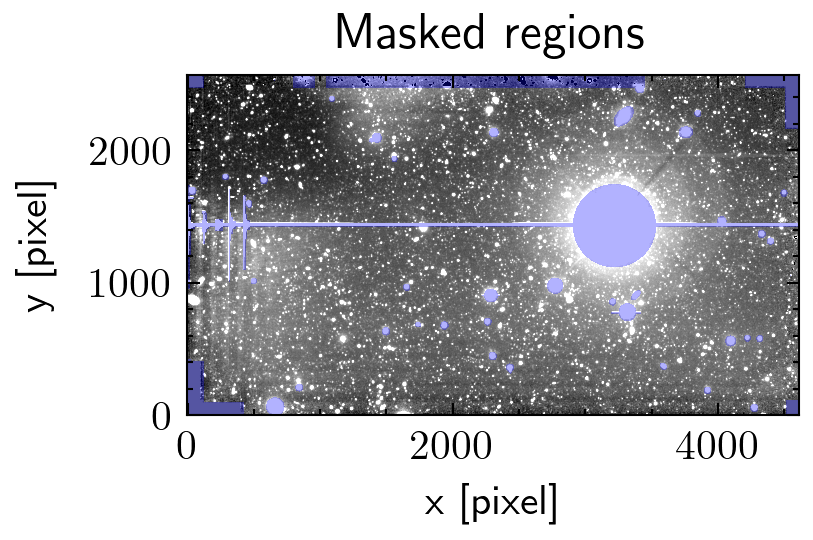

In [17]:
# --- Initialize mask array ---
mask_bool = np.ones_like(crop, dtype=bool)

# --- Apply manual masking ---

# Lower left corner 
mask_bool.T[0:402, 0:96] = False
mask_bool.T[400:423, 0:25] = False
mask_bool.T[0:100, 96:406] = False
mask_bool.T[100:118, 96:117] = False
mask_bool.T[0:25, 405:424] = False

# Upper left corner
mask_bool.T[0:122, 2469:-1] = False

# Upper middle noise 
mask_bool.T[1050:3450, 2469:-1] = False

# Lower right corner
mask_bool.T[4517:-1, 0:115] = False

# Upper right corner
mask_bool.T[4213:-1, 2472:-1] = False
mask_bool.T[4508:-1, 2161:-1] = False

# Mask out some edges
mask_bool.T[:, 0:6] = False
mask_bool.T[:, -5:-1] = False
mask_bool.T[797:960, 2470:-1] = False
mask_bool.T[0:13, 1580:1730] = False
mask_bool.T[0:13, 960:1510] = False
mask_bool.T[399:406, 22:96] = False


# Central star
mask_bool = mask_circle(mask_bool, center=(3220, 1430), radius=310)

# Horizontal stripe
mask_bool.T[:, 1427:1448] = False

# Weird spikes / stripes to the left
mask_bool.T[0:20, 1200:1600] = False
mask_bool.T[118:146, 1448:1524] = False
mask_bool.T[118:131, 1298:1448] = False
mask_bool.T[130:140, 1381:1448] = False
mask_bool.T[140:158, 1407:1448] = False
mask_bool.T[215:266, 1392:1474] = False
mask_bool.T[314:320, 1010:1702] = False
mask_bool.T[314:327, 1322:1529] = False
mask_bool.T[327:343, 1374:1492] = False
mask_bool.T[343:362, 1412:1464] = False
mask_bool.T[426:435, 1100:1655] = False
mask_bool.T[435:446, 1330:1515] = False
mask_bool.T[435:467, 1405:1467] = False
mask_bool.T[19:25, 1394:1461] = False
mask_bool.T[29:55, 1412:1428] = False
mask_bool.T[30:33, 1447:1450] = False
mask_bool.T[12:45, 1634:1644] = False

# Mask out some other obvious stars (ones with diffraction spikes)
mask_bool = mask_circle(mask_bool, center=(3410, 2463), radius=32)
mask_bool = mask_circle(mask_bool, center=(3318, 778), radius=63)
mask_bool.T[3375:3417, 771:778] = False
mask_bool.T[3201:3257, 770:778] = False
mask_bool.T[3201:3257, 770:778] = False
mask_bool = mask_circle(mask_bool, center=(2773, 977), radius=57)
mask_bool = mask_circle(mask_bool, center=(2288, 903), radius=48)
mask_bool.T[2329:2356, 902:907] = False
mask_bool.T[2223:2246, 902:907] = False
mask_bool = mask_circle(mask_bool, center=(36, 1692), radius=28)
mask_bool = mask_circle(mask_bool, center=(662, 65), radius=66)
mask_bool = mask_circle(mask_bool, center=(843, 209), radius=26)
mask_bool = mask_circle(mask_bool, center=(287, 1797), radius=22)
mask_bool = mask_circle(mask_bool, center=(577, 1772), radius=26)
mask_bool = mask_circle(mask_bool, center=(464,1598), radius=22)
mask_bool = mask_circle(mask_bool, center=(469,1575), radius=10)
mask_bool = mask_circle(mask_bool, center=(500,1011), radius=20)
mask_bool = mask_circle(mask_bool, center=(1090, 2385), radius=20)
mask_bool = mask_circle(mask_bool, center=(1428, 2092), radius=34)
mask_bool = mask_circle(mask_bool, center=(1387,2075), radius=14)
mask_bool = mask_circle(mask_bool, center=(1561,1932), radius=20)
mask_bool = mask_circle(mask_bool, center=(2311,2132), radius=32)

mask_bool = mask_ellipse(mask_bool, center=(3290, 2254), radii=(90, 50), angle=45)
mask_bool = mask_circle(mask_bool, center=(1498, 633), radius=28)
mask_bool = mask_circle(mask_bool, center=(1653, 966), radius=24)
mask_bool = mask_circle(mask_bool, center=(1740, 684), radius=18)
mask_bool = mask_circle(mask_bool, center=(1938, 678), radius=28)
mask_bool = mask_circle(mask_bool, center=(2264, 705), radius=26)
mask_bool = mask_circle(mask_bool, center=(2302, 446), radius=28)
mask_bool = mask_circle(mask_bool, center=(2431, 359), radius=28)
mask_bool = mask_circle(mask_bool, center=(2436, 328), radius=10)
mask_bool = mask_circle(mask_bool, center=(3207, 855), radius=24)
mask_bool = mask_ellipse(mask_bool, center=(3381, 905), radii=(44, 20), angle=48)
mask_bool = mask_circle(mask_bool, center=(3847, 2276), radius=22)
mask_bool = mask_ellipse(mask_bool, center=(3759, 2134), radii=(52, 42), angle=0)
mask_bool = mask_circle(mask_bool, center=(4030, 1466), radius=32)
mask_bool = mask_circle(mask_bool, center=(4499, 1676), radius=24)
mask_bool = mask_circle(mask_bool, center=(4274, 55), radius=27)
mask_bool = mask_circle(mask_bool, center=(4331, 1367), radius=27)
mask_bool = mask_circle(mask_bool, center=(4397, 1313), radius=24)
mask_bool = mask_circle(mask_bool, center=(4316, 578), radius=23)
mask_bool = mask_circle(mask_bool, center=(4223, 582), radius=23)
mask_bool = mask_circle(mask_bool, center=(4096, 560), radius=38)
mask_bool = mask_ellipse(mask_bool, center=(3589, 369), radii=(28, 20), angle=-45)
mask_bool = mask_circle(mask_bool, center=(3923, 188), radius=24)


# Weird saturated features
mask_bool.T[116:137, 1525:1537] = False
mask_bool.T[116:118, 1387:1467] = False
mask_bool.T[157:161, 1422:1426] = False
mask_bool.T[157:171, 1424:1427] = False
mask_bool.T[654:659, 2529:2531] = False
mask_bool.T[3599:3601, 2534:2536] = False
mask_bool.T[4547:4549, 1053:1055] = False

# Extra
mask_bool.T[100:118, 109:405] = False
mask_bool.T[22:101, 404:408] = False
mask_bool.T[399:420, 22:96] = False
mask_bool.T[4208:4219, 2476:-1] = False

# --- Detect remaining bright regions ---
yy, xx = np.where((crop > 5e4) & mask_bool)


# --- Visualize masked regions ---
plt.figure(figsize=(2 * aspect_ratio, 2), dpi=300)

# Base grayscale image
plt.imshow(crop, cmap='gray', origin='lower',
           vmin=np.percentile(crop[mask_bool], 5),
           vmax=np.percentile(crop[mask_bool], 95))

# Fill masked regions semi-transparently using contourf
plt.contourf(~mask_bool, levels=[0.5, 1], colors='blue', alpha=0.3)

plt.scatter(xx, yy, s=10, marker='+', c='red', linewidths=1)
plt.title('Masked regions')
plt.xlabel('x [pixel]')
plt.ylabel('y [pixel]', labelpad=8)
plt.tight_layout()
plt.show()

In [30]:
plt.close()

In [6]:
num_masked = np.count_nonzero(mask_bool == False)
total_pixels = mask_bool.size
fraction_masked = num_masked / total_pixels
print(f"Masked: {num_masked:,} / {total_pixels:,} pixels ({fraction_masked:.2%})")


Masked: 1,011,492 / 11,850,270 pixels (8.54%)


## Replot histogram

Masked std: 19.451481689634434
Initial std: 23.61904348008115


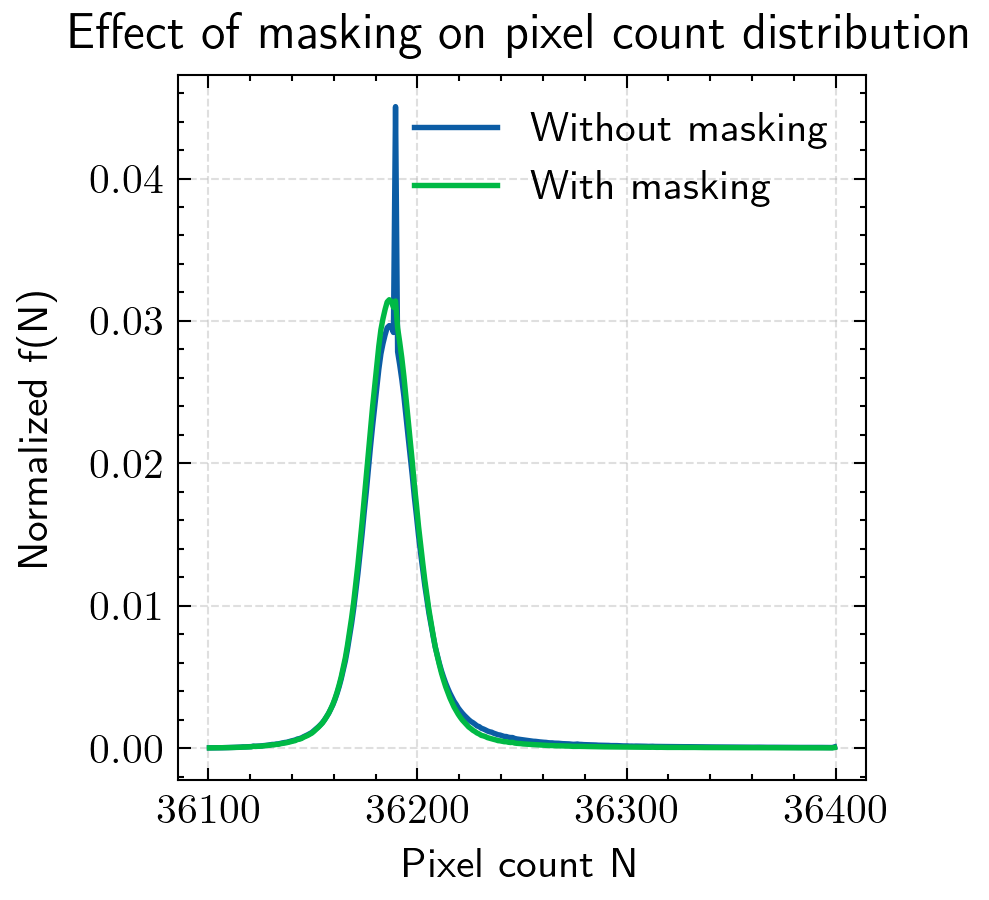

In [19]:
# --- Flatten both arrays ---
pixels_all = crop.flatten()
pixels_masked = crop[mask_bool].flatten()

# --- Define range and bins ---
min_count, max_count = 36.1e3, 36.4e3
bin_edges = np.arange(min_count, max_count + 1, 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# --- Apply range selection ---
pixels_all_in_range = pixels_all[(pixels_all >= min_count) & (pixels_all <= max_count)]
pixels_masked_in_range = pixels_masked[(pixels_masked >= min_count) & (pixels_masked <= max_count)]

# --- Manual histogram (normalized) ---
hist_all, _ = np.histogram(pixels_all_in_range, bins=bin_edges, density=True)
hist_masked, _ = np.histogram(pixels_masked_in_range, bins=bin_edges, density=True)

print('Masked std:', np.std(pixels_masked_in_range))
print('Initial std:', np.std(pixels_all_in_range))

# --- Plot as smooth line ---
plt.figure(figsize=(4*0.8, 4*0.8), dpi=300)
plt.plot(bin_centers, hist_all, lw=1.3, label='Without masking')
plt.plot(bin_centers, hist_masked, lw=1.3, label='With masking')
plt.xlabel('Pixel count N')
plt.ylabel('Normalized f(N)', labelpad=8)
plt.title('Effect of masking on pixel count distribution')
plt.legend()
plt.grid(alpha=0.4, linestyle='--')
plt.tight_layout()
plt.show()

# Object detection

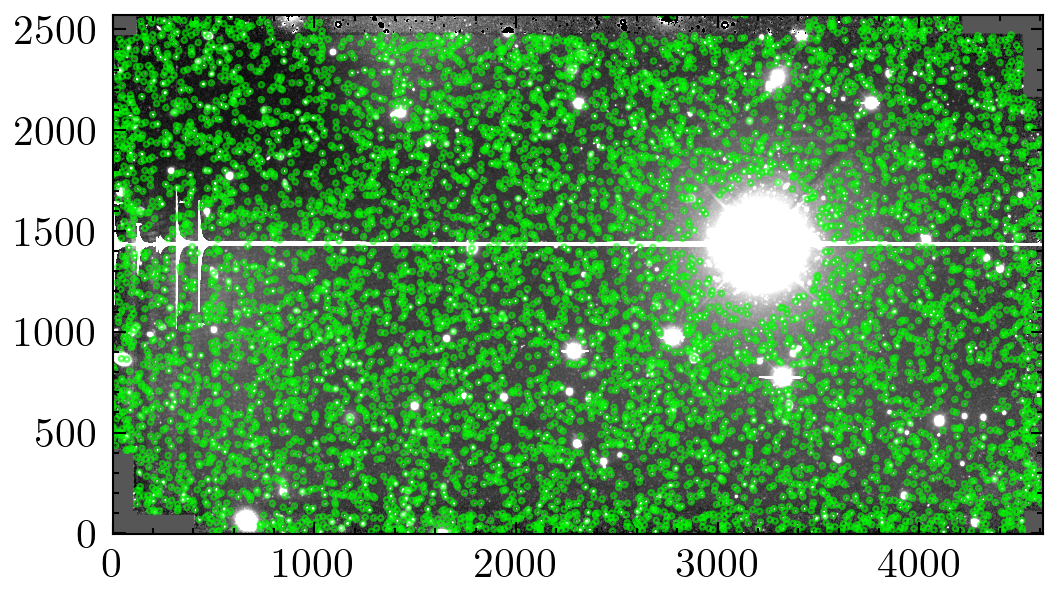

 xcenter   ycenter    true_count  
--------- --------- --------------
 4356.471 5.1742228      2802.7988
4412.5637 6.3942875      680.95474
844.57961 6.7127365      2182.4609
1463.4016 8.1742666      8084.8161
1593.2306 8.5182278     -230.24932
3031.3883 7.1697837      1475.8476
4118.9131 8.8429836      9260.6005
      ...       ...            ...
530.55686  2573.862      102.76557
2446.8899 2569.8719 -5.8207661e-11
2716.4392 2573.0659              0
2778.9602 2565.6964              0
3089.0433 2569.8913              0
 3134.636  2570.697              0
3785.0912  2571.684      188.21569
Length = 6900 rows


In [8]:
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats

r_aperture = 6  # pixels

# --- image and mask ---
# test
#img = crop[0:150, 0:150]
#mask = mask_bool[0:150, 0:150]
# full
img = crop
mask = mask_bool

# --- background stats ---
mean, median, std = sigma_clipped_stats(img, sigma=3.0, mask=~mask)

# --- detect stellar objects ---
daofind = DAOStarFinder(fwhm=2*r_aperture, threshold=4*std)
sources = daofind(img - median, mask=~mask)

if sources is None or len(sources) == 0:
    print("No sources found.")
else:
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=r_aperture)
    annuli = CircularAnnulus(positions, r_in=1.5 * r_aperture, r_out=2 * r_aperture)

    # --- background measurement ---
    aperstats = ApertureStats(img, annuli, mask=~mask)
    bkg_mean = aperstats.mean  # mean background per pixel
    aperture_area = apertures.area_overlap(img, mask=~mask) # only considering the valid pixels
    total_bkg = bkg_mean * aperture_area # total background

    # --- aperture photometry ---
    phot_table = aperture_photometry(img, apertures, mask=~mask)
    phot_table['total_bkg'] = total_bkg
    phot_table['true_count'] = phot_table['aperture_sum'] - phot_table['total_bkg']

    # --- plot ---
    plt.figure(figsize=(4, 4), dpi=300)
    plt.imshow(img, cmap='gray', origin='lower',
               vmin=np.percentile(img, 5), vmax=np.percentile(img, 95))
    apertures.plot(color='lime', lw=1.2, alpha=0.6)
    plt.show()

    # --- results ---
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'

    print(phot_table['xcenter', 'ycenter', 'true_count'])

# Calibrate flux

In [9]:
count = phot_table['true_count']
exp_time = header['EXPTIME'] # exposure time in second
calibration = header['MAGZPT']
calibration_err = header['MAGZRR']
intru_zero = header['MAGZPT']
m = intru_zero -2.5*np.log10(count/exp_time) 
#sigma_m = np.sqrt( (2.5 / np.log(10) * np.sqrt(count) / count)**2 + calibration_err**2 )
# unc comes from sqrt(count) and the unc in calibration err 

/var/folders/hg/0kdv7y6569v6ky7qntrm11l40000gn/T/ipykernel_36287/3189171371.py:6: RuntimeWarning: divide by zero encountered in log10
  m = intru_zero -2.5*np.log10(count/exp_time)
/var/folders/hg/0kdv7y6569v6ky7qntrm11l40000gn/T/ipykernel_36287/3189171371.py:6: RuntimeWarning: invalid value encountered in log10
  m = intru_zero -2.5*np.log10(count/exp_time)


In [10]:
len(m)

6900

# Magnitude plot

Slope = 0.4072 ± 0.0033
Intercept = -6.4007 ± 0.0797
Chi² = 195.07, Reduced χ² = 16.26


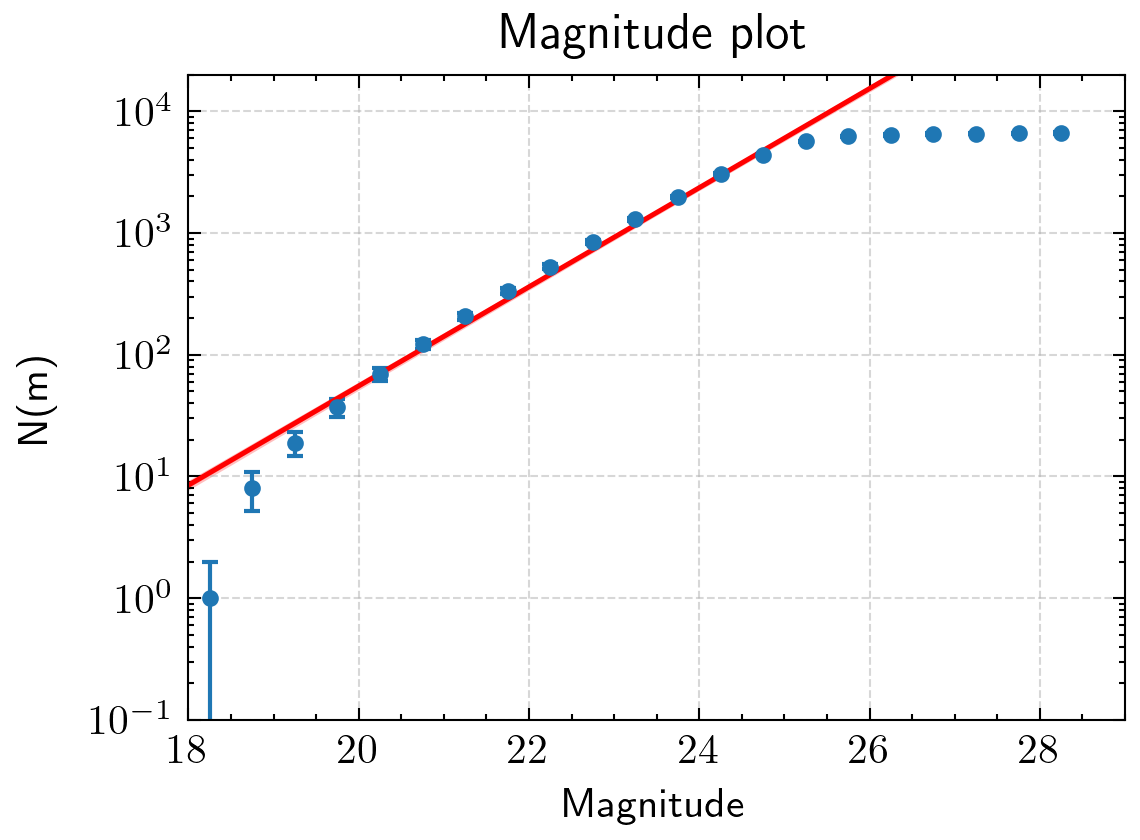

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- Exponential model ---
def exp_model(m, a, b):
    return 10 ** (a * m + b)

# --- χ² function ---
def chi2_func(params, x, y, yerr):
    a, b = params
    model = exp_model(x, a, b)
    return np.sum(((y - model) / yerr) ** 2)

# --- Bin data ---
m_valid = m[~np.isnan(m)]
bins = np.arange(10, 29, 0.5)
N, edges = np.histogram(m_valid, bins=bins)
cum_N = np.cumsum(N)
m_centers = 0.5 * (edges[1:] + edges[:-1])

valid = cum_N > 0
x_all = m_centers[valid]
y_all = cum_N[valid]
yerr_all = np.sqrt(y_all)  # Poisson statistics

# --- Select fixed fitting range ---
xmin, xmax = 16, 25
fit_mask = (x_all >= xmin) & (x_all <= xmax)
x_fit, y_fit, yerr_fit = x_all[fit_mask], y_all[fit_mask], yerr_all[fit_mask]

# --- χ² minimization ---
p0 = [0.3, -5]  # initial guess
res = minimize(chi2_func, p0, args=(x_fit, y_fit, yerr_fit))
a, b = res.x

# --- Estimate uncertainties from Hessian ---
eps = np.sqrt(np.finfo(float).eps)
J = np.zeros((len(x_fit), 2))
for i, param in enumerate(res.x):
    dp = np.zeros_like(res.x)
    dp[i] = eps * (abs(param) + 1)
    f_plus = exp_model(x_fit, *(res.x + dp))
    f_minus = exp_model(x_fit, *(res.x - dp))
    J[:, i] = (f_plus - f_minus) / (2 * dp[i])

cov = np.linalg.inv(J.T @ np.diag(1 / yerr_fit**2) @ J)
a_err, b_err = np.sqrt(np.diag(cov))

# --- Compute χ² ---
chi2 = chi2_func([a, b], x_fit, y_fit, yerr_fit)
chi2_red = chi2 / (len(y_fit) - len(res.x))

print(f"Slope = {a:.4f} ± {a_err:.4f}")
print(f"Intercept = {b:.4f} ± {b_err:.4f}")
print(f"Chi² = {chi2:.2f}, Reduced χ² = {chi2_red:.2f}")

# --- Plot ---
plt.figure(figsize=(4, 3), dpi=300)
plt.errorbar(x_all, y_all, yerr=yerr_all, fmt='o', ms=3, capsize=2, color='tab:blue')

x_fit_line = np.linspace(17, 28, 200)
y_fit_line = exp_model(x_fit_line, a, b)

# Jacobian of model wrt parameters [a, b]
J = np.zeros((len(x_fit_line), 2))
J[:, 0] = np.log(10) * x_fit_line * y_fit_line   # ∂y/∂a
J[:, 1] = np.log(10) * y_fit_line                # ∂y/∂b

# Variance from covariance matrix
y_var = np.einsum('ij,jk,ik->i', J, cov, J)
y_err = np.sqrt(y_var)

# --- Plot with uncertainty band ---
plt.plot(x_fit_line, y_fit_line, 'r-', lw=1.2)
plt.fill_between(x_fit_line, y_fit_line - y_err, y_fit_line + y_err,
                 color='r', alpha=0.25)
plt.title('Magnitude plot')
plt.xlabel('Magnitude')
plt.ylabel(r'N(m)', labelpad=8)
plt.yscale('log')
plt.xlim(18, 29)
plt.ylim(1e-1, 2e4)
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()


## What does the literature say? 

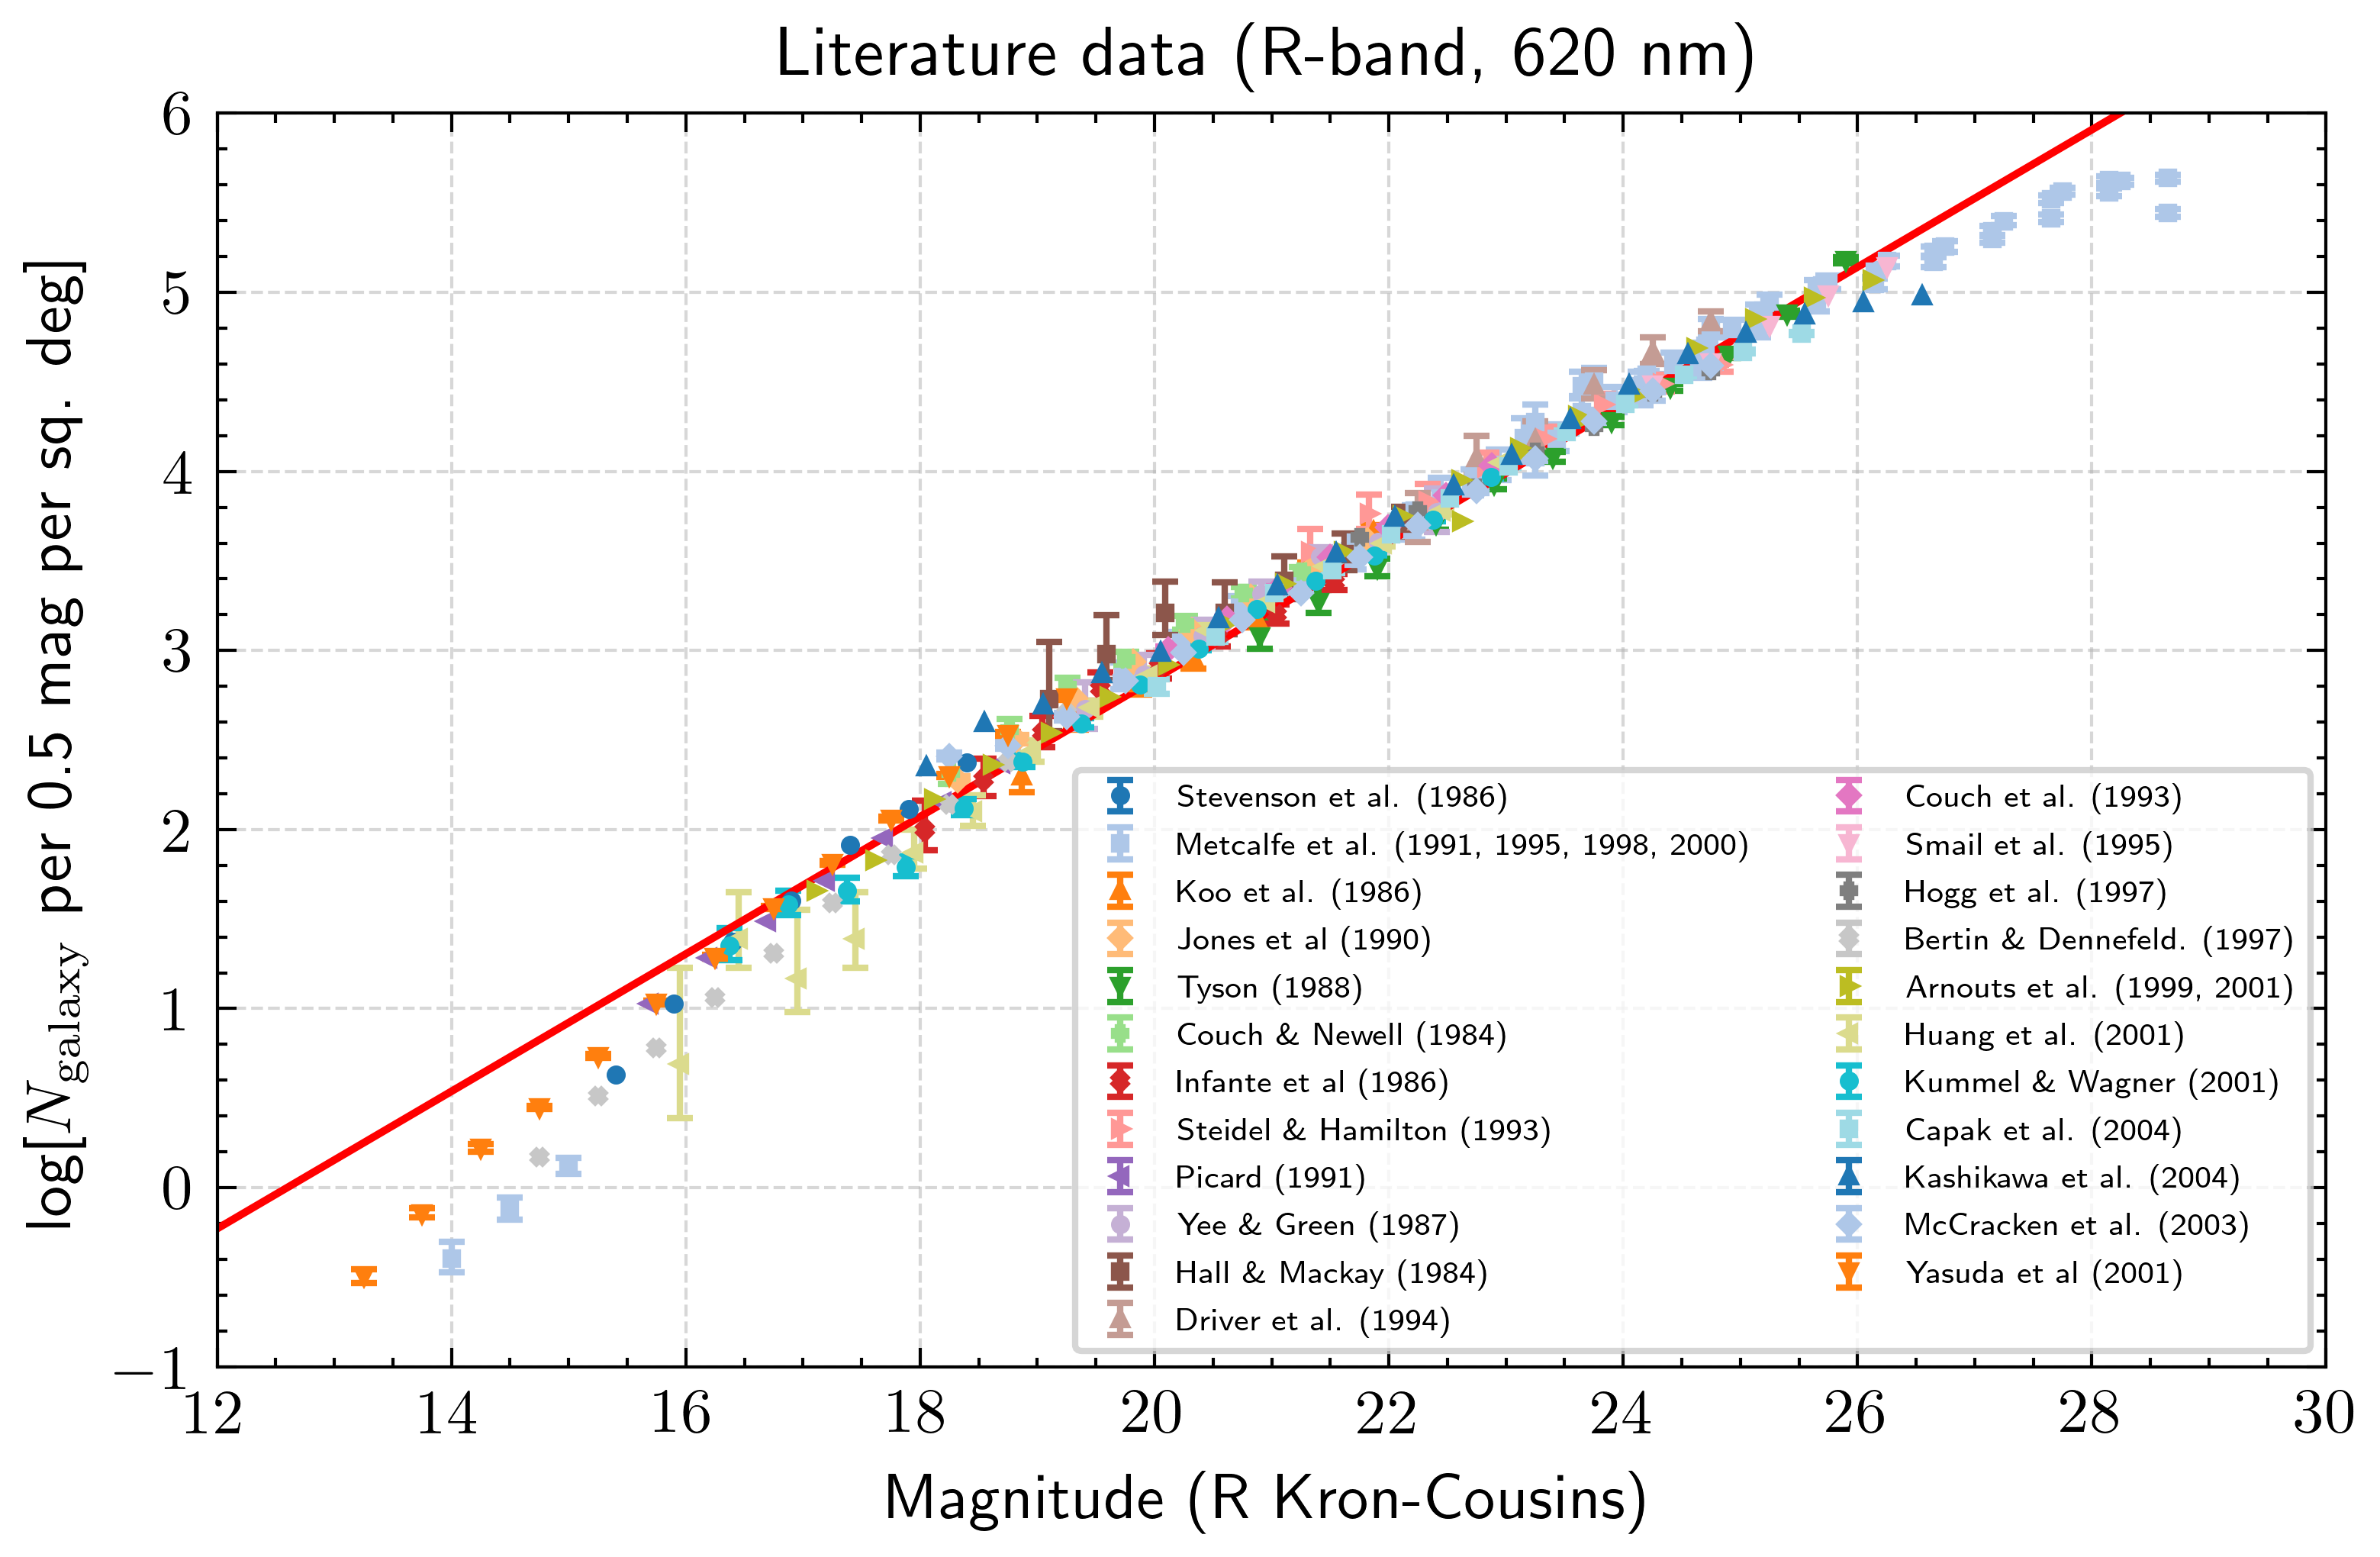

Slope = 0.384 ± 0.003
Intercept = -4.832 ± 0.063


In [17]:
from collections import defaultdict

def linear(m, a, b):
    return a * m + b

def plot_Rband(file_path="data/literature/R-band.txt", legend=True):
    data = defaultdict(lambda: {
        "m": [], "logN": [], "err_lower": [], "err_upper": [], "years": set()
    })
    current_label = None

    # --- parse file ---
    with open(file_path, "r") as f:
        for line in f:
            # header (potential legend)
            if re.search(r'[A-Za-z]', line) and not re.match(r'^\s*\d', line):
                label = line.strip().replace('&', r'\&')
                if label:
                    current_label = label
            # numeric data
            elif re.match(r'^\s*-?\d', line) and current_label:
                nums = [float(x) for x in re.findall(r'-?\d+\.?\d*(?:[eE][-+]?\d+)?', line)]
                if len(nums) >= 2:
                    m = nums[0]
                    if len(nums) >= 5:
                        val = nums[2]  # corrected value
                        lower, upper = nums[3], nums[4]
                    elif len(nums) == 4:
                        val = nums[1]
                        lower, upper = nums[2], nums[3]
                    else:
                        val = nums[1]
                        lower = upper = np.nan

                    # extract author and year for merging
                    match = re.search(r'([A-Z][a-zA-Z\-]+ et al\.) \((\d{4})\)', current_label)
                    if match:
                        author, year = match.groups()
                        merged_label = author
                        data[merged_label]["years"].add(year)
                    else:
                        merged_label = current_label

                    d = data[merged_label]
                    d["m"].append(m)
                    d["logN"].append(val)
                    d["err_lower"].append(lower)
                    d["err_upper"].append(upper)

    # --- merge years into labels ---
    merged_data = {}
    for label, d in data.items():
        years = sorted(list(d["years"]))
        year_str = ", ".join(years) if years else ""
        label_full = f"{label} ({year_str})" if year_str else label
        merged_data[label_full] = d

    # --- setup color + marker cycle ---
    colors = plt.cm.tab20(np.linspace(0, 1, 20))
    markers = ["o", "s", "^", "D", "v", "P", "X", ">", "<"]
    color_cyc = cycle(colors)
    marker_cyc = cycle(markers)

    # --- collect all points for fit ---
    all_m, all_logN, all_err = [], [], []

    plt.figure(figsize=(4.5*1.2, 3*1.2), dpi=600)

    # --- plot data ---
    for label, d in merged_data.items():
        m = np.array(d["m"])
        logN = np.array(d["logN"])
        yerr = np.vstack([d["err_lower"], d["err_upper"]])

        if legend:
            color = next(color_cyc)
            marker = next(marker_cyc)
        else:
            color = 'black'
            marker = 'o'

        plt.errorbar(m, logN, yerr=yerr, fmt=marker, ms=2,
                     capsize=2, color=color, label=label if legend else None)

        all_m.extend(m)
        all_logN.extend(logN)
        all_err.extend(0.5 * (np.array(d["err_lower"]) + np.array(d["err_upper"])))

    if legend:
        plt.legend(fontsize=5, ncol=2, loc='lower right', frameon=True)
        plt.tight_layout(rect=[0, 0, 0.8, 1])
    else:
        plt.tight_layout()

    # --- fit ---
    all_m = np.array(all_m)
    all_logN = np.array(all_logN)
    all_err = np.array(all_err)
    mask = (all_m >= 12) & (all_m <= 30)

    popt, pcov = curve_fit(linear, all_m[mask], all_logN[mask])
    slope, intercept = popt
    slope_err, intercept_err = np.sqrt(np.diag(pcov))

    # --- fit line ---
    x_line = np.linspace(12, 30, 200)
    plt.plot(x_line, linear(x_line, *popt), 'r-', lw=1.2,
             label=f"slope={slope:.3f}±{slope_err:.3f}")
    plt.xlabel("Magnitude (R Kron-Cousins)")
    plt.ylabel(r"log[$N_\mathrm{galaxy}$ per 0.5 mag per sq. deg]")
    plt.xlim(12, 30)
    plt.ylim(-1, 6)
    plt.title("Literature data (R-band, 620 nm)", fontsize=11)
    if not legend:
        plt.text(13, 5.5, f"slope={slope:.3f}±{slope_err:.3f}", color='red', fontsize=8)
    plt.grid(alpha=0.5, linestyle='--')
    plt.tight_layout()
    plt.show()

    print(f"Slope = {slope:.3f} ± {slope_err:.3f}")
    print(f"Intercept = {intercept:.3f} ± {intercept_err:.3f}")


# Example usage:
plot_Rband("data/literature/R-band.txt", legend=True)
